In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import time
import os
import copy

# Writer for Tensorboard
train_writer = SummaryWriter('runs/ResNet_50/train')
valid_writer = SummaryWriter('runs/ResNet_50/valid')

In [2]:
offline = True
if offline == True:
    data_dir = "./Dataset"
else:
    from google.colab import drive
    drive.mount('/content/drive')
    data_dir = "/content/drive/My Drive/Dataset"

In [3]:
# Data normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(255),
        transforms.CenterCrop(125),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(255),
        transforms.CenterCrop(125),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(255),
        transforms.CenterCrop(125),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}


In [4]:
train_data = image_datasets['train']
valid_data = image_datasets['valid']
test_data = image_datasets['valid']

assert(train_data.classes==test_data.classes)
n_classes = len(train_data.classes)
print(f"Dataset train size: {dataset_sizes['train']}")
print(f"Dataset validation size: {dataset_sizes['valid']}")
print(f"Dataset test size: {dataset_sizes['test']}")
print(f"# Classes: {n_classes}")

Dataset train size: 23271
Dataset validation size: 6684
Dataset test size: 2580
# Classes: 11


In [5]:
batch_size = 16
num_workers = 4

dataloader_train = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True, num_workers=num_workers)
dataloader_test = torch.utils.data.DataLoader(test_data, batch_size, num_workers=num_workers)
dataloader_valid = torch.utils.data.DataLoader(valid_data, batch_size, num_workers=num_workers)

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size,
                                              num_workers=num_workers,
                                              shuffle=True,
                                              pin_memory=True)
              for x in ['train', 'valid', 'test']}

class_names = train_data.classes
print("Class names: ")
for x in class_names:
  print(x)

Class names: 
Bacterial_spot
Early_blight
Late_blight
Leaf_Mold
Septoria_leaf_spot
Spider_mites Two-spotted_spider_mite
Target_Spot
Tomato_Yellow_Leaf_Curl_Virus
Tomato_mosaic_virus
healthy
powdery_mildew


In [6]:
if (torch.backends.mps.is_available() and torch.backends.mps.is_built()):
    print("Using MPS")
    device = torch.device("mps")
    dtype = torch.float32
elif torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    print("Using CUDA")
    device = torch.device("cuda:0")
    dtype = torch.float32
else :
    print("Using CPU")
    device = torch.device("cpu")
    dtype = torch.float32

Using MPS


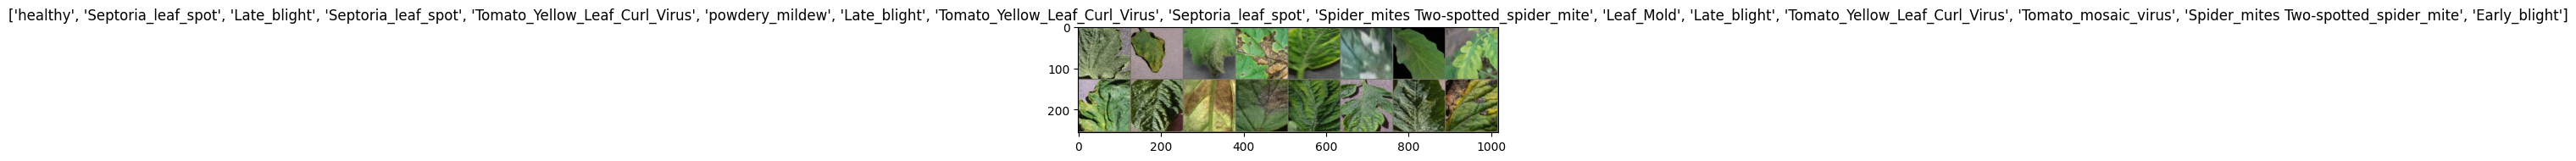

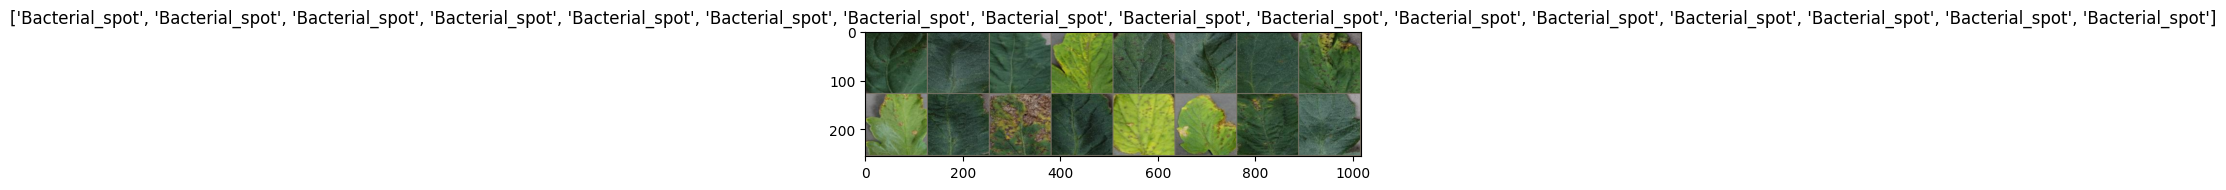

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloader_train))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Get a batch of test data
inputs, classes = next(iter(dataloader_test))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device, dtype=dtype)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]} \n actual: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            i = 0
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                if i % 100 == 0:
                  print(i)
                  print(f"{round(i/len(dataloaders[phase]),2)}%")
                i +=1
                inputs = inputs.to(device, dtype=dtype)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), "./Dataset/resnet50.pt")
        if phase == 'train':
          train_writer.add_scalar('Loss/train', epoch_loss, epoch)
          train_writer.add_scalar('Accuracy/train', epoch_acc, epoch)
        elif phase == 'valid':
          valid_writer.add_scalar('Loss/valid', epoch_loss, epoch)
          valid_writer.add_scalar('Accuracy/valid', epoch_acc, epoch)

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best valid Acc: {best_acc:4f}')

    # Visualize Tensorboard
    train_writer.flush()
    train_writer.close()

    valid_writer.flush()
    valid_writer.close()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [10]:
model_ft = models.resnet50(pretrained=True)
# Train just the last layer
for layer in model_ft.parameters():
    layer.requires_grad = True

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.NLLLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

/opt/anaconda3/envs/corso_ml/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/corso_ml/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
0
0.0%
100
0.07%
200
0.14%
300
0.21%
400
0.27%
500
0.34%
600
0.41%
700
0.48%
800
0.55%
900
0.62%
1000
0.69%
1100
0.76%
1200
0.82%
1300
0.89%
1400
0.96%
train Loss: -176.2653 Acc: 0.6704
0
0.0%
100
0.24%
200
0.48%
300
0.72%
400
0.96%
valid Loss: -462.5977 Acc: 0.7959
Epoch 1/24
----------
0
0.0%
100
0.07%
200
0.14%
300
0.21%
400
0.27%
500
0.34%
600
0.41%
700
0.48%
800
0.55%
900
0.62%
1000
0.69%
1100
0.76%
1200
0.82%
1300
0.89%
1400
0.96%
train Loss: -840.0781 Acc: 0.7497
0
0.0%
100
0.24%
200
0.48%
300
0.72%
400
0.96%
valid Loss: -1355.0382 Acc: 0.8317
Epoch 2/24
----------
0
0.0%
100
0.07%
200
0.14%
300
0.21%
400
0.27%
500
0.34%
600
0.41%
700
0.48%
800
0.55%
900
0.62%
1000
0.69%
1100
0.76%
1200
0.82%
1300
0.89%
1400
0.96%
train Loss: -1958.8123 Acc: 0.7837
0
0.0%
100
0.24%
200
0.48%
300
0.72%
400
0.96%
valid Loss: -2689.6889 Acc: 0.8345
Epoch 3/24
----------
0
0.0%
100
0.07%
200
0.14%
300
0.21%
400
0.27%
500
0.34%
600
0.41%
700
0.48%
800
0.55%
900
0.62%
1000
0.69%


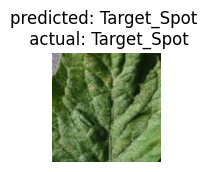

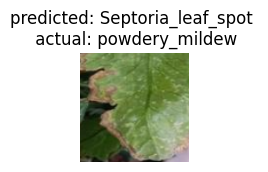

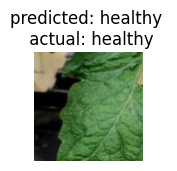

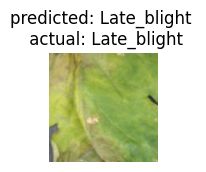

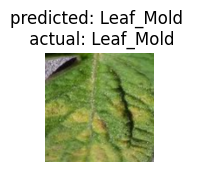

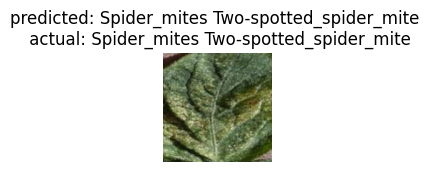

In [12]:
visualize_model(model_ft)

In [13]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}%') 
    

In [14]:
def test_model():
    # Load the model
    model_ft.load_state_dict(torch.load("./Dataset/resnet50.pt"))
    model_ft.eval()
    model_ft.to(device)

    test_dataloader = dataloaders['test']
    check_accuracy(test_dataloader, model_ft)

In [15]:
test_model()

Got 2162 / 2580 with accuracy 83.80%
